In [1]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas_datareader as web
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
import pickle
import seaborn as sns
import datetime as dt
import yfinance as yf
import talib
from tqdm.notebook import tqdm
%matplotlib inline


class LinearModel:
    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)
        self.vW = 0
        self.vb = 0
        self.losses = []
        
    def predict(self, s):
        return s.dot(self.W) + self.b
    
    def sgd(self, s, Y, learning_rate=0.001, momentum=0.9):
        num_values = np.prod(Y.shape)
        Y_hat = self.predict(s)
        Y_hat = self.predict(s)  # shape (1, 8)
        gW = 2 * s.T.dot(Y_hat - Y) / num_values  # vector shape (7, 8)
        gb = 2 * (Y_hat - Y).sum(axis=0) / num_values  # scalar

        self.vW = momentum * self.vW - learning_rate * gW  # vector shape (7, 8)
        self.vb = momentum * self.vb - learning_rate * gb  # scalar

        self.W += self.vW  # vector shape (7, 8)
        self.b += self.vb  # scalar

        mse = np.mean((Y_hat - Y) ** 2)
        self.losses.append(mse)
        
        
    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)


    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz['W']
        self.b = npz['b']
        
        
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
class Env:
    def __init__(self, data, capital):
        self.stock_price_history = data['Adj Close']
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.current_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 5 #[stock price, stock_owned, cash__in_hand, rsi, mom]
        self.save_position = []
        self.save_port_val = [] 
        self.save_cash = []
        self.stock_value = []
        self.action_space = [0,1,2]
        self.sell_buy = []
        self.save_stock_price = []
        self.rsi = data['rsi']
        self.mom = data['mom']
        self.reset()
        
        
    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi[self.current_step]
        vector[4] = self.mom[self.current_step]
        return vector
    
    
    def reset(self):
        self.current_step = 0
        self.stock_owned = 0
        self.stock_price = self.stock_price_history[self.current_step]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital] 
        self.save_cash = [self.capital]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self.save_stock_price = [self.stock_price]
        return self.state_vector()
    

    
    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    
        
      
    def trade(self, action):
        '''
        action 0 = hold
        action 1 = buy
        action 2 = sell
        '''
        assert action in self.action_space
        
        if action == 1 and self.stock_owned == 0:
            self.stock_owned += (self.cash_in_hand / self.stock_price)
            self.cash_in_hand = 0
            self.sell_buy.append('buy')
            
        elif action == 2 and self.cash_in_hand == 0:
            self.cash_in_hand += (self.stock_owned * self.stock_price)
            self.stock_owned = 0
            self.sell_buy.append('sell')    
        
                
        else:
            self.sell_buy.append('hold')
            
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
          
        
                
    def step(self, action):
        assert action in self.action_space
        
        prev_val = self.port_val()
        self.current_step += 1
        self.stock_price = self.stock_price_history[self.current_step]
        
        self.trade(action)
        current_val = self.port_val()
        reward = current_val - prev_val
        done = self.current_step == self.n_step - 1
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
#                 'current_val': self.port_val(),
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy':self.sell_buy
               }
        
        return self.state_vector(), reward, done, info
    
    
def get_scaler(env):
    states = []
    for i in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler


class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action


    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.model.predict(next_state), axis=1)

        target_full = self.model.predict(state)
        target_full[0, action] = target

        # Run one training step
        self.model.sgd(state, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)
        
        
def play_one_episode(agent, env, is_train):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        
        if is_train == 'train':
            agent.train(state, action, reward, next_state, done)
        
        state = next_state
    
    return info

In [17]:
stock_name = 'ibm'.upper()
stock_data = pd.read_csv(f'../train_test_data/{stock_name}.csv', index_col=['Date'], parse_dates=True)

train_data = stock_data.loc[:'2018-01-01']
test_data = stock_data.loc['2018-01-01':]



models_folder = 'q_learn'
rewards_folder = 'q_reward'
maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)
num_episodes = 2000
batch_size = 32
capital = 1000
data = stock_data['Adj Close'].values
n_timesteps = data.shape[0]


env = Env(train_data, capital)
state_size = env.state_dim
action_size = 3
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

  0%|          | 0/2000 [00:00<?, ?it/s]

episode: 1/2000, episode end value: 772.79, duration: 0:00:00.163055
episode: 2/2000, episode end value: 659.36, duration: 0:00:00.165087
episode: 3/2000, episode end value: 1125.77, duration: 0:00:00.163085
episode: 4/2000, episode end value: 1092.63, duration: 0:00:00.163056
episode: 5/2000, episode end value: 905.04, duration: 0:00:00.167073
episode: 6/2000, episode end value: 1107.36, duration: 0:00:00.163098
episode: 7/2000, episode end value: 1244.53, duration: 0:00:00.161048
episode: 8/2000, episode end value: 860.93, duration: 0:00:00.161049
episode: 9/2000, episode end value: 973.05, duration: 0:00:00.164037
episode: 10/2000, episode end value: 1178.41, duration: 0:00:00.165037
episode: 11/2000, episode end value: 957.22, duration: 0:00:00.161042
episode: 12/2000, episode end value: 1013.29, duration: 0:00:00.167038
episode: 13/2000, episode end value: 1285.82, duration: 0:00:00.165043
episode: 14/2000, episode end value: 989.74, duration: 0:00:00.166043
episode: 15/2000, epis

episode: 118/2000, episode end value: 1159.53, duration: 0:00:00.163023
episode: 119/2000, episode end value: 928.61, duration: 0:00:00.158998
episode: 120/2000, episode end value: 1236.33, duration: 0:00:00.161319
episode: 121/2000, episode end value: 912.62, duration: 0:00:00.169099
episode: 122/2000, episode end value: 1122.35, duration: 0:00:00.161023
episode: 123/2000, episode end value: 1030.70, duration: 0:00:00.155041
episode: 124/2000, episode end value: 1068.95, duration: 0:00:00.161036
episode: 125/2000, episode end value: 960.34, duration: 0:00:00.161049
episode: 126/2000, episode end value: 1083.88, duration: 0:00:00.164037
episode: 127/2000, episode end value: 956.35, duration: 0:00:00.157035
episode: 128/2000, episode end value: 1040.39, duration: 0:00:00.163036
episode: 129/2000, episode end value: 801.94, duration: 0:00:00.162039
episode: 130/2000, episode end value: 1028.06, duration: 0:00:00.156037
episode: 131/2000, episode end value: 1099.58, duration: 0:00:00.1650

episode: 233/2000, episode end value: 1073.25, duration: 0:00:00.165049
episode: 234/2000, episode end value: 990.11, duration: 0:00:00.158035
episode: 235/2000, episode end value: 1008.49, duration: 0:00:00.165037
episode: 236/2000, episode end value: 987.95, duration: 0:00:00.158035
episode: 237/2000, episode end value: 1017.92, duration: 0:00:00.164037
episode: 238/2000, episode end value: 911.19, duration: 0:00:00.166037
episode: 239/2000, episode end value: 1014.54, duration: 0:00:00.161036
episode: 240/2000, episode end value: 1043.96, duration: 0:00:00.165037
episode: 241/2000, episode end value: 1034.66, duration: 0:00:00.164037
episode: 242/2000, episode end value: 990.36, duration: 0:00:00.157016
episode: 243/2000, episode end value: 1081.88, duration: 0:00:00.161548
episode: 244/2000, episode end value: 895.25, duration: 0:00:00.164037
episode: 245/2000, episode end value: 1052.31, duration: 0:00:00.165037
episode: 246/2000, episode end value: 909.22, duration: 0:00:00.16502

episode: 348/2000, episode end value: 1008.68, duration: 0:00:00.163048
episode: 349/2000, episode end value: 888.02, duration: 0:00:00.162036
episode: 350/2000, episode end value: 1016.63, duration: 0:00:00.162030
episode: 351/2000, episode end value: 1038.04, duration: 0:00:00.163043
episode: 352/2000, episode end value: 937.21, duration: 0:00:00.164037
episode: 353/2000, episode end value: 1008.79, duration: 0:00:00.165051
episode: 354/2000, episode end value: 938.89, duration: 0:00:00.159036
episode: 355/2000, episode end value: 1000.44, duration: 0:00:00.165024
episode: 356/2000, episode end value: 1116.41, duration: 0:00:00.163036
episode: 357/2000, episode end value: 699.46, duration: 0:00:00.167050
episode: 358/2000, episode end value: 729.99, duration: 0:00:00.166025
episode: 359/2000, episode end value: 1039.13, duration: 0:00:00.165049
episode: 360/2000, episode end value: 967.50, duration: 0:00:00.158048
episode: 361/2000, episode end value: 995.18, duration: 0:00:00.164031

episode: 463/2000, episode end value: 1140.46, duration: 0:00:00.162036
episode: 464/2000, episode end value: 1000.00, duration: 0:00:00.166038
episode: 465/2000, episode end value: 1111.63, duration: 0:00:00.165051
episode: 466/2000, episode end value: 1051.73, duration: 0:00:00.157044
episode: 467/2000, episode end value: 962.97, duration: 0:00:00.158041
episode: 468/2000, episode end value: 1057.37, duration: 0:00:00.164850
episode: 469/2000, episode end value: 1056.38, duration: 0:00:00.166025
episode: 470/2000, episode end value: 1012.41, duration: 0:00:00.156047
episode: 471/2000, episode end value: 1036.02, duration: 0:00:00.171032
episode: 472/2000, episode end value: 1063.74, duration: 0:00:00.159042
episode: 473/2000, episode end value: 916.92, duration: 0:00:00.163030
episode: 474/2000, episode end value: 976.00, duration: 0:00:00.161048
episode: 475/2000, episode end value: 1162.77, duration: 0:00:00.166037
episode: 476/2000, episode end value: 1002.67, duration: 0:00:00.16

episode: 579/2000, episode end value: 1298.19, duration: 0:00:00.166036
episode: 580/2000, episode end value: 1200.36, duration: 0:00:00.163050
episode: 581/2000, episode end value: 1151.38, duration: 0:00:00.167024
episode: 582/2000, episode end value: 1271.98, duration: 0:00:00.166036
episode: 583/2000, episode end value: 1304.73, duration: 0:00:00.161036
episode: 584/2000, episode end value: 891.25, duration: 0:00:00.162052
episode: 585/2000, episode end value: 885.10, duration: 0:00:00.158041
episode: 586/2000, episode end value: 1207.20, duration: 0:00:00.168020
episode: 587/2000, episode end value: 1175.65, duration: 0:00:00.162055
episode: 588/2000, episode end value: 1054.28, duration: 0:00:00.158014
episode: 589/2000, episode end value: 905.97, duration: 0:00:00.164036
episode: 590/2000, episode end value: 1055.44, duration: 0:00:00.167037
episode: 591/2000, episode end value: 1174.18, duration: 0:00:00.164037
episode: 592/2000, episode end value: 1041.44, duration: 0:00:00.16

episode: 694/2000, episode end value: 1277.90, duration: 0:00:00.163039
episode: 695/2000, episode end value: 1252.22, duration: 0:00:00.159036
episode: 696/2000, episode end value: 1027.19, duration: 0:00:00.165036
episode: 697/2000, episode end value: 956.15, duration: 0:00:00.167037
episode: 698/2000, episode end value: 1078.99, duration: 0:00:00.160062
episode: 699/2000, episode end value: 982.93, duration: 0:00:00.166022
episode: 700/2000, episode end value: 983.38, duration: 0:00:00.167037
episode: 701/2000, episode end value: 966.43, duration: 0:00:00.169038
episode: 702/2000, episode end value: 1169.11, duration: 0:00:00.166038
episode: 703/2000, episode end value: 1052.78, duration: 0:00:00.160048
episode: 704/2000, episode end value: 978.83, duration: 0:00:00.163020
episode: 705/2000, episode end value: 1035.39, duration: 0:00:00.162038
episode: 706/2000, episode end value: 1142.75, duration: 0:00:00.160033
episode: 707/2000, episode end value: 1054.52, duration: 0:00:00.1690

episode: 810/2000, episode end value: 1020.52, duration: 0:00:00.161037
episode: 811/2000, episode end value: 1121.67, duration: 0:00:00.165037
episode: 812/2000, episode end value: 1115.40, duration: 0:00:00.165037
episode: 813/2000, episode end value: 1151.13, duration: 0:00:00.166038
episode: 814/2000, episode end value: 1134.03, duration: 0:00:00.160057
episode: 815/2000, episode end value: 1048.09, duration: 0:00:00.167030
episode: 816/2000, episode end value: 1149.88, duration: 0:00:00.158034
episode: 817/2000, episode end value: 1198.65, duration: 0:00:00.165051
episode: 818/2000, episode end value: 1040.74, duration: 0:00:00.160022
episode: 819/2000, episode end value: 1241.30, duration: 0:00:00.161037
episode: 820/2000, episode end value: 1010.27, duration: 0:00:00.160035
episode: 821/2000, episode end value: 941.07, duration: 0:00:00.164036
episode: 822/2000, episode end value: 1175.80, duration: 0:00:00.164037
episode: 823/2000, episode end value: 962.83, duration: 0:00:00.1

episode: 925/2000, episode end value: 1093.03, duration: 0:00:00.165052
episode: 926/2000, episode end value: 1010.73, duration: 0:00:00.161022
episode: 927/2000, episode end value: 1202.97, duration: 0:00:00.165050
episode: 928/2000, episode end value: 971.62, duration: 0:00:00.155036
episode: 929/2000, episode end value: 1152.32, duration: 0:00:00.165037
episode: 930/2000, episode end value: 855.17, duration: 0:00:00.161037
episode: 931/2000, episode end value: 729.65, duration: 0:00:00.165035
episode: 932/2000, episode end value: 614.60, duration: 0:00:00.164037
episode: 933/2000, episode end value: 917.46, duration: 0:00:00.162026
episode: 934/2000, episode end value: 1277.03, duration: 0:00:00.166051
episode: 935/2000, episode end value: 894.16, duration: 0:00:00.166037
episode: 936/2000, episode end value: 982.07, duration: 0:00:00.167037
episode: 937/2000, episode end value: 980.14, duration: 0:00:00.162036
episode: 938/2000, episode end value: 979.84, duration: 0:00:00.165036
e

episode: 1039/2000, episode end value: 1000.94, duration: 0:00:00.166046
episode: 1040/2000, episode end value: 975.34, duration: 0:00:00.161036
episode: 1041/2000, episode end value: 978.57, duration: 0:00:00.165037
episode: 1042/2000, episode end value: 960.22, duration: 0:00:00.159026
episode: 1043/2000, episode end value: 996.74, duration: 0:00:00.157672
episode: 1044/2000, episode end value: 1097.57, duration: 0:00:00.165303
episode: 1045/2000, episode end value: 824.79, duration: 0:00:00.157589
episode: 1046/2000, episode end value: 841.84, duration: 0:00:00.166030
episode: 1047/2000, episode end value: 928.38, duration: 0:00:00.164036
episode: 1048/2000, episode end value: 974.43, duration: 0:00:00.165028
episode: 1049/2000, episode end value: 990.70, duration: 0:00:00.160036
episode: 1050/2000, episode end value: 978.03, duration: 0:00:00.165043
episode: 1051/2000, episode end value: 1109.89, duration: 0:00:00.166047
episode: 1052/2000, episode end value: 883.81, duration: 0:00

episode: 1154/2000, episode end value: 1017.86, duration: 0:00:00.158073
episode: 1155/2000, episode end value: 1000.00, duration: 0:00:00.158055
episode: 1156/2000, episode end value: 1073.90, duration: 0:00:00.165013
episode: 1157/2000, episode end value: 990.25, duration: 0:00:00.164249
episode: 1158/2000, episode end value: 1005.95, duration: 0:00:00.163022
episode: 1159/2000, episode end value: 990.75, duration: 0:00:00.156049
episode: 1160/2000, episode end value: 996.29, duration: 0:00:00.164035
episode: 1161/2000, episode end value: 1047.83, duration: 0:00:00.157046
episode: 1162/2000, episode end value: 1025.27, duration: 0:00:00.165036
episode: 1163/2000, episode end value: 973.10, duration: 0:00:00.156034
episode: 1164/2000, episode end value: 977.83, duration: 0:00:00.157028
episode: 1165/2000, episode end value: 984.35, duration: 0:00:00.165037
episode: 1166/2000, episode end value: 991.87, duration: 0:00:00.164034
episode: 1167/2000, episode end value: 950.27, duration: 0

episode: 1267/2000, episode end value: 1135.90, duration: 0:00:00.166076
episode: 1268/2000, episode end value: 1016.12, duration: 0:00:00.160055
episode: 1269/2000, episode end value: 1022.17, duration: 0:00:00.165066
episode: 1270/2000, episode end value: 1134.36, duration: 0:00:00.160189
episode: 1271/2000, episode end value: 1105.34, duration: 0:00:00.165908
episode: 1272/2000, episode end value: 1020.14, duration: 0:00:00.160073
episode: 1273/2000, episode end value: 1001.01, duration: 0:00:00.164077
episode: 1274/2000, episode end value: 1023.42, duration: 0:00:00.165056
episode: 1275/2000, episode end value: 1032.59, duration: 0:00:00.166077
episode: 1276/2000, episode end value: 1044.95, duration: 0:00:00.167036
episode: 1277/2000, episode end value: 1403.01, duration: 0:00:00.160043
episode: 1278/2000, episode end value: 1025.77, duration: 0:00:00.159022
episode: 1279/2000, episode end value: 961.16, duration: 0:00:00.165036
episode: 1280/2000, episode end value: 1039.67, dura

episode: 1380/2000, episode end value: 975.27, duration: 0:00:00.183040
episode: 1381/2000, episode end value: 1002.99, duration: 0:00:00.181030
episode: 1382/2000, episode end value: 1018.29, duration: 0:00:00.182033
episode: 1383/2000, episode end value: 960.53, duration: 0:00:00.183041
episode: 1384/2000, episode end value: 977.68, duration: 0:00:00.179040
episode: 1385/2000, episode end value: 1016.24, duration: 0:00:00.181032
episode: 1386/2000, episode end value: 981.14, duration: 0:00:00.185041
episode: 1387/2000, episode end value: 1057.59, duration: 0:00:00.175040
episode: 1388/2000, episode end value: 970.41, duration: 0:00:00.182039
episode: 1389/2000, episode end value: 1015.08, duration: 0:00:00.182039
episode: 1390/2000, episode end value: 1009.08, duration: 0:00:00.174045
episode: 1391/2000, episode end value: 961.44, duration: 0:00:00.173045
episode: 1392/2000, episode end value: 1011.60, duration: 0:00:00.182052
episode: 1393/2000, episode end value: 967.43, duration: 

episode: 1494/2000, episode end value: 955.86, duration: 0:00:00.160035
episode: 1495/2000, episode end value: 966.40, duration: 0:00:00.164036
episode: 1496/2000, episode end value: 1146.15, duration: 0:00:00.166037
episode: 1497/2000, episode end value: 1147.97, duration: 0:00:00.163023
episode: 1498/2000, episode end value: 1047.33, duration: 0:00:00.166050
episode: 1499/2000, episode end value: 1174.33, duration: 0:00:00.156040
episode: 1500/2000, episode end value: 822.87, duration: 0:00:00.163023
episode: 1501/2000, episode end value: 1141.34, duration: 0:00:00.155035
episode: 1502/2000, episode end value: 1221.75, duration: 0:00:00.163120
episode: 1503/2000, episode end value: 1218.18, duration: 0:00:00.156301
episode: 1504/2000, episode end value: 1137.74, duration: 0:00:00.164346
episode: 1505/2000, episode end value: 1160.96, duration: 0:00:00.156238
episode: 1506/2000, episode end value: 1114.05, duration: 0:00:00.166037
episode: 1507/2000, episode end value: 1169.49, durati

episode: 1607/2000, episode end value: 1220.46, duration: 0:00:00.164029
episode: 1608/2000, episode end value: 1184.95, duration: 0:00:00.164035
episode: 1609/2000, episode end value: 1129.87, duration: 0:00:00.161524
episode: 1610/2000, episode end value: 1176.49, duration: 0:00:00.166092
episode: 1611/2000, episode end value: 1353.87, duration: 0:00:00.162054
episode: 1612/2000, episode end value: 1123.97, duration: 0:00:00.167025
episode: 1613/2000, episode end value: 1196.26, duration: 0:00:00.162044
episode: 1614/2000, episode end value: 1097.74, duration: 0:00:00.160066
episode: 1615/2000, episode end value: 1210.45, duration: 0:00:00.158087
episode: 1616/2000, episode end value: 1061.23, duration: 0:00:00.164108
episode: 1617/2000, episode end value: 1148.63, duration: 0:00:00.163064
episode: 1618/2000, episode end value: 1241.78, duration: 0:00:00.165055
episode: 1619/2000, episode end value: 1197.78, duration: 0:00:00.166058
episode: 1620/2000, episode end value: 1026.20, dur

episode: 1721/2000, episode end value: 1095.24, duration: 0:00:00.166044
episode: 1722/2000, episode end value: 1039.30, duration: 0:00:00.157037
episode: 1723/2000, episode end value: 1043.35, duration: 0:00:00.167025
episode: 1724/2000, episode end value: 992.36, duration: 0:00:00.165052
episode: 1725/2000, episode end value: 1186.79, duration: 0:00:00.167035
episode: 1726/2000, episode end value: 1026.01, duration: 0:00:00.165037
episode: 1727/2000, episode end value: 994.94, duration: 0:00:00.164037
episode: 1728/2000, episode end value: 1083.34, duration: 0:00:00.162036
episode: 1729/2000, episode end value: 975.60, duration: 0:00:00.160035
episode: 1730/2000, episode end value: 1028.17, duration: 0:00:00.157035
episode: 1731/2000, episode end value: 1058.64, duration: 0:00:00.166037
episode: 1732/2000, episode end value: 1040.01, duration: 0:00:00.165035
episode: 1733/2000, episode end value: 962.04, duration: 0:00:00.165035
episode: 1734/2000, episode end value: 954.18, duration

episode: 1836/2000, episode end value: 996.16, duration: 0:00:00.166076
episode: 1837/2000, episode end value: 1010.62, duration: 0:00:00.161084
episode: 1838/2000, episode end value: 975.16, duration: 0:00:00.163011
episode: 1839/2000, episode end value: 974.04, duration: 0:00:00.155050
episode: 1840/2000, episode end value: 978.82, duration: 0:00:00.166036
episode: 1841/2000, episode end value: 960.76, duration: 0:00:00.159036
episode: 1842/2000, episode end value: 942.21, duration: 0:00:00.165036
episode: 1843/2000, episode end value: 1002.72, duration: 0:00:00.162035
episode: 1844/2000, episode end value: 1001.75, duration: 0:00:00.159042
episode: 1845/2000, episode end value: 1014.03, duration: 0:00:00.163030
episode: 1846/2000, episode end value: 1000.73, duration: 0:00:00.164030
episode: 1847/2000, episode end value: 1005.82, duration: 0:00:00.166037
episode: 1848/2000, episode end value: 985.73, duration: 0:00:00.160035
episode: 1849/2000, episode end value: 998.79, duration: 0

episode: 1950/2000, episode end value: 1074.19, duration: 0:00:00.162039
episode: 1951/2000, episode end value: 1034.30, duration: 0:00:00.168042
episode: 1952/2000, episode end value: 1055.08, duration: 0:00:00.174025
episode: 1953/2000, episode end value: 1015.88, duration: 0:00:00.165046
episode: 1954/2000, episode end value: 1169.63, duration: 0:00:00.165041
episode: 1955/2000, episode end value: 1021.86, duration: 0:00:00.160117
episode: 1956/2000, episode end value: 1061.38, duration: 0:00:00.163043
episode: 1957/2000, episode end value: 1032.61, duration: 0:00:00.166044
episode: 1958/2000, episode end value: 1096.81, duration: 0:00:00.166040
episode: 1959/2000, episode end value: 959.17, duration: 0:00:00.159048
episode: 1960/2000, episode end value: 1042.96, duration: 0:00:00.164034
episode: 1961/2000, episode end value: 1084.48, duration: 0:00:00.164033
episode: 1962/2000, episode end value: 1102.93, duration: 0:00:00.167028
episode: 1963/2000, episode end value: 993.87, durat

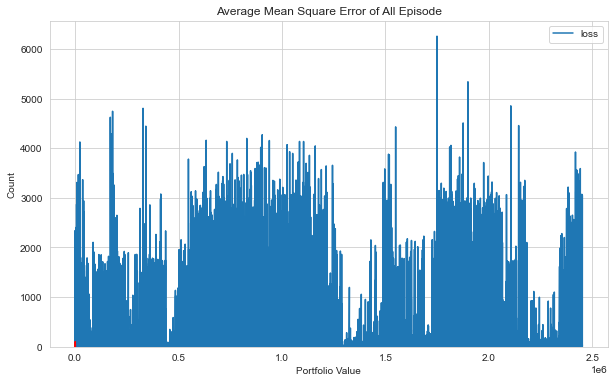

In [18]:
#train


mode = 'train'

portfolio_value = []

if mode == 'test':
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    num_episodes = 1
    env = Env(test_data, capital)
    agent.epsilon = 0
    agent.load(f'{models_folder}/linear.npz')


for e in tqdm(range(num_episodes)):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val['portfolio_value'][-1]:.2f}, duration: {dt}")
    portfolio_value.append(val['portfolio_value'][-1]) 


if mode == 'train':
    # save the DQN
    agent.save(f'{models_folder}/linear.npz')

    # save the scaler
    with open(f'{models_folder}/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # plot losses
    loss = agent.model.losses
    losses = pd.DataFrame(loss, columns=['loss'])
    losses.plot(figsize=(10,6))
    plt.title('Average Mean Square Error of All Episode')
    plt.xlabel('Step')
    plt.ylabel('Mean Square Error')

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
sns.histplot(portfolio_value, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

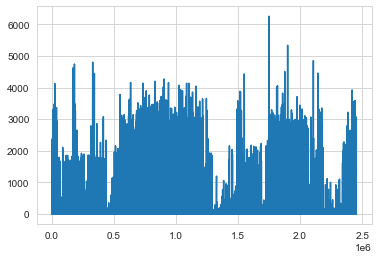

In [19]:
plt.plot(agent.model.losses)

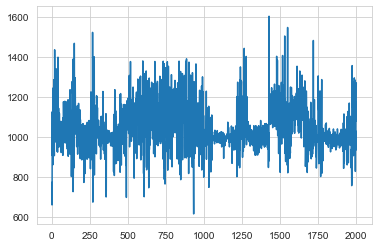

In [20]:
plt.plot(portfolio_value)

episode: 1/1, episode end value: 810.35, duration: 0:00:00.050031
Sell: 0 times, Buy: 1 times


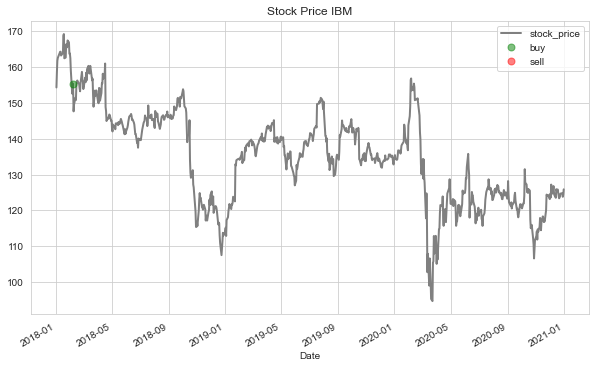

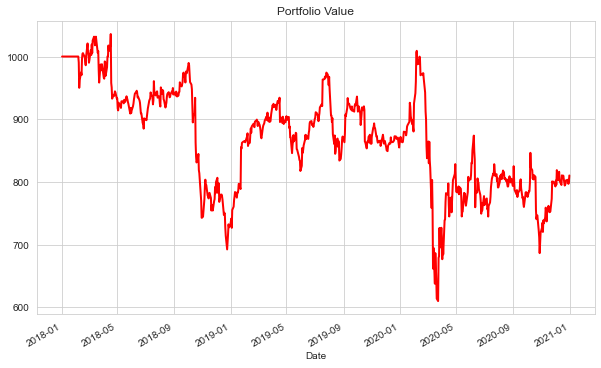

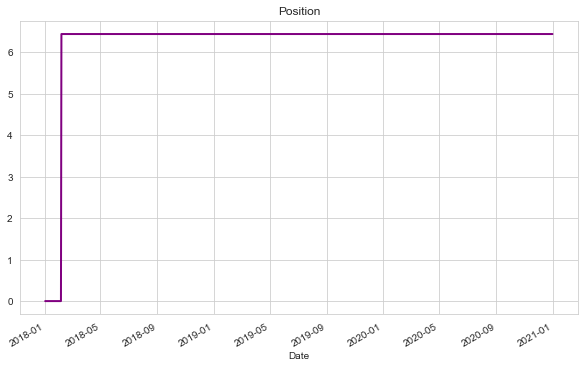

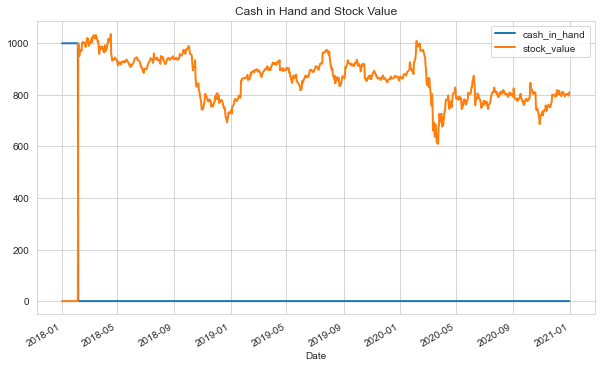

In [21]:
#test

mode = 'test'

portfolio_value = []

if mode == 'test':
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    num_episodes = 1
    env = Env(test_data, capital)
    agent.epsilon = 0
    agent.load(f'{models_folder}/linear.npz')


for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val['portfolio_value'][-1]:.2f}, duration: {dt}")
    portfolio_value.append(val['portfolio_value'][-1])
    
print(f"Sell: {env.sell_buy.count('sell')} times, Buy: {env.sell_buy.count('buy')} times")



result = pd.DataFrame(val)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw=2);
result['marker_buy'].plot(style='o', ms=7, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()



result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=2);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=2);
plt.title('Cash in Hand and Stock Value');
plt.show()

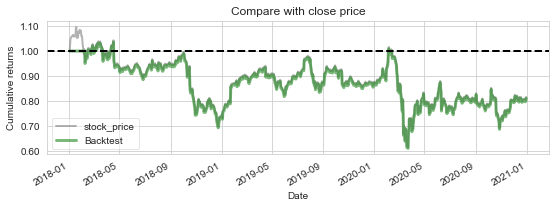

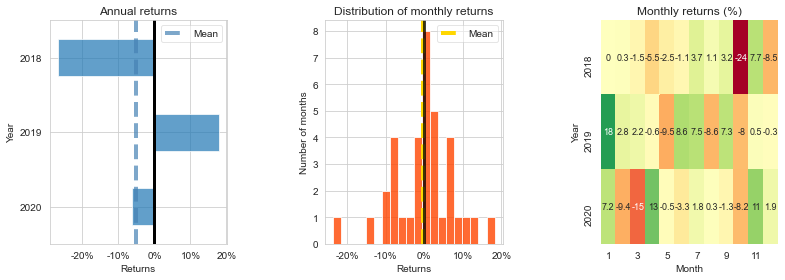

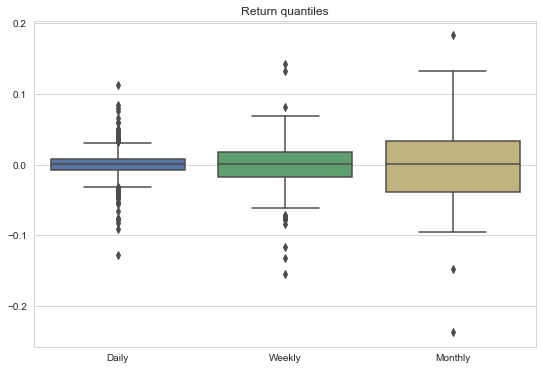

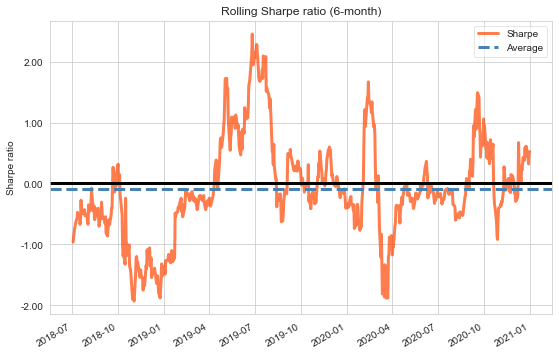

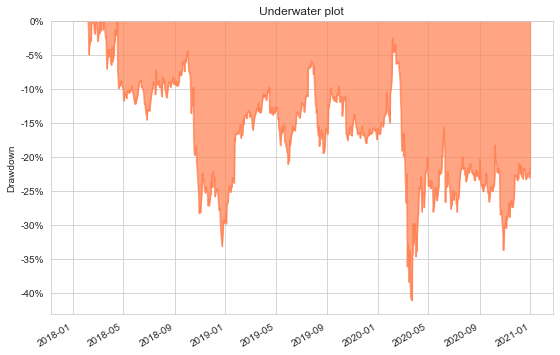

In [22]:
import pyfolio as pf
sns.set_style('whitegrid')

bt_returns = result['portfolio_value'].pct_change()
price = result['stock_price'].pct_change()



plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);



plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);